#### Load and process data

In [1]:
using QuantumACES, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Initialise data loading parameters
dist = 3
r_1 = 0.075 / 100
r_2 = 0.5 / 100
r_m = 2.0 / 100
total_std_log = sqrt(log(10 / 9))
seed = UInt(0)
unrotated_param = get_unrotated_param(dist)
dep_param = get_dep_param(r_1, r_2, r_m)
log_param = get_log_param(r_1, r_2, r_m, total_std_log; seed=seed)
rotated_planar = get_circuit(unrotated_param, dep_param)
dist_max = 9
dist_range = collect(3:dist_max)
dense_range = collect(2:0.025:(dist_max+1))
# Load the metadata
metadata_dict = load("data/design_metadata_$(unrotated_param.circuit_name).jld2")
@assert unrotated_param == metadata_dict["unrotated_param"]
@assert dep_param == metadata_dict["dep_param"]
dep_param_set = metadata_dict["dep_param_set"]
tuple_number_set = metadata_dict["tuple_number_set"]
repeat_numbers_set = metadata_dict["repeat_numbers_set"]
gls_tuple_number = metadata_dict["gls_tuple_number"]
gls_repeat_numbers = metadata_dict["gls_repeat_numbers"]
ols_tuple_number = metadata_dict["ols_tuple_number"]
ols_repeat_numbers = metadata_dict["ols_repeat_numbers"]
dep_idx = 14
@assert dep_param == dep_param_set[dep_idx]
dep_worst_idx = 3
wls_tuple_number = tuple_number_set[dep_idx]
wls_repeat_numbers = repeat_numbers_set[dep_idx]
wls_worst_tuple_number = tuple_number_set[dep_worst_idx]
wls_worst_repeat_numbers = repeat_numbers_set[dep_worst_idx]
triv_tuple_number = length(get_basic_tuple_set(rotated_planar))
triv_repeat_numbers = Int[]
# Load the data
dep_planar_scaling_wls = load_scaling(unrotated_param, dep_param, wls_tuple_number, wls_repeat_numbers, :wls)
log_planar_scaling_wls = load_scaling(unrotated_param, log_param, wls_tuple_number, wls_repeat_numbers, :wls)
dep_planar_scaling_gls = load_scaling(unrotated_param, dep_param, gls_tuple_number, gls_repeat_numbers, :gls)
dep_planar_scaling_ols = load_scaling(unrotated_param, dep_param, ols_tuple_number, ols_repeat_numbers, :ols)
dep_planar_scaling_wls_worst = load_scaling(unrotated_param, dep_param, wls_worst_tuple_number, wls_worst_repeat_numbers, :wls);
dep_planar_scaling_basic = load_scaling(unrotated_param, dep_param, triv_tuple_number, triv_repeat_numbers, :wls);

In [3]:
# Fit the scaling data
# WLS depolarising
(
    wls_gate_number,
    wls_gate_params,
    wls_gate_eigenvalue_number,
    wls_gate_eigenvalue_params,
    wls_trace_fit,
    wls_trace_params,
    wls_trace_sq_fit,
    wls_trace_sq_params,
    wls_expectation_fit,
    wls_variance_fit,
) = depolarising_fits(dep_planar_scaling_wls)
# WLS log-normal
(wls_expectation_fit_log, wls_variance_fit_log) =
    lognormal_fits(log_planar_scaling_wls, wls_gate_eigenvalue_number, wls_trace_params, wls_trace_sq_params)
# GLS depolarising
(
    gls_gate_number,
    gls_gate_params,
    gls_gate_eigenvalue_number,
    gls_gate_eigenvalue_params,
    gls_trace_fit,
    gls_trace_params,
    gls_trace_sq_fit,
    gls_trace_sq_params,
    gls_expectation_fit,
    gls_variance_fit,
) = depolarising_fits(dep_planar_scaling_gls)
@assert gls_gate_params == wls_gate_params
@assert gls_gate_eigenvalue_params == wls_gate_eigenvalue_params
# OLS depolarising
(
    ols_gate_number,
    ols_gate_params,
    ols_gate_eigenvalue_number,
    ols_gate_eigenvalue_params,
    ols_trace_fit,
    ols_trace_params,
    ols_trace_sq_fit,
    ols_trace_sq_params,
    ols_expectation_fit,
    ols_variance_fit,
) = depolarising_fits(dep_planar_scaling_ols)
@assert ols_gate_params == wls_gate_params
@assert ols_gate_eigenvalue_params == wls_gate_eigenvalue_params
# Worst WLS depolarising
(
    wls_worst_gate_number,
    wls_worst_gate_params,
    wls_worst_gate_eigenvalue_number,
    wls_worst_gate_eigenvalue_params,
    wls_worst_trace_fit,
    wls_worst_trace_params,
    wls_worst_trace_sq_fit,
    wls_worst_trace_sq_params,
    wls_worst_expectation_fit,
    wls_worst_variance_fit,
) = depolarising_fits(dep_planar_scaling_wls_worst)
@assert wls_worst_gate_params == wls_gate_params
@assert wls_worst_gate_eigenvalue_params == wls_gate_eigenvalue_params
# Trivial depolarising
(
    triv_gate_number,
    triv_gate_params,
    triv_gate_eigenvalue_number,
    triv_gate_eigenvalue_params,
    triv_trace_fit,
    triv_trace_params,
    triv_trace_sq_fit,
    triv_trace_sq_params,
    triv_expectation_fit,
    triv_variance_fit,
) = depolarising_fits(dep_planar_scaling_basic)
@assert triv_gate_params == wls_gate_params
@assert triv_gate_eigenvalue_params == wls_gate_eigenvalue_params
println("The gate number as a function of code distance is: G(d) = $(wls_gate_params[1]) + $(wls_gate_params[2])d + $(wls_gate_params[3])d^2.")
println("The gate eigenvalue number as a function of code distance is: N(d) = $(wls_gate_eigenvalue_params[1]) + $(wls_gate_eigenvalue_params[2])d + $(wls_gate_eigenvalue_params[3])d^2.")

The gate number as a function of code distance is: G(d) = 4 + -20d + 24d^2.
The gate eigenvalue number as a function of code distance is: N(d) = 54 + -180d + 144d^2.


In [4]:
# Process the WLS depolarising data
@assert dep_planar_scaling_wls.dist_range == dist_range
wls_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_wls.merit_scaling]
wls_variance_scaling = [merit.variance for merit in dep_planar_scaling_wls.merit_scaling]
wls_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_wls.merit_scaling]
wls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_wls.merit_scaling]
wls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_wls.merit_scaling]
wls_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_wls.merit_scaling]
wls_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_wls.merit_scaling]
wls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_wls.merit_scaling]
wls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_wls.merit_scaling]
# WLS data relative errors
wls_trace_fit_rel_error = (wls_trace_fit(dist_range) .- wls_trace_scaling) ./ wls_trace_scaling
wls_trace_sq_fit_rel_error = (wls_trace_sq_fit(dist_range) .- wls_trace_sq_scaling) ./ wls_trace_sq_scaling
wls_expectation_fit_rel_error = (wls_expectation_fit(dist_range) .- wls_expectation_scaling) ./ wls_expectation_scaling
wls_std_fit_rel_error = (sqrt.(wls_variance_fit(dist_range)) .- wls_stdev_scaling) ./ wls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_trace_fit_rel_error, wls_trace_sq_fit_rel_error, wls_expectation_fit_rel_error, wls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 9.3987e-10  │ -6.9499e-10 │ 4.7366e-10      │ -8.1650e-10    │
│ -6.7006e-10 │ 4.8204e-10  │ -3.3631e-10     │ 5.7573e-10     │
│ -7.9358e-11 │ 6.0497e-11  │ -3.9770e-11     │ 6.9905e-11     │
│ 6.8284e-11  │ -4.8609e-11 │ 3.4192e-11      │ -5.8433e-11    │
│ 7.2432e-11  │ -5.2081e-11 │ 3.6254e-11      │ -6.2247e-11    │
│ 2.6940e-11  │ -1.9446e-11 │ 1.3481e-11      │ -2.3190e-11    │
│ -3.4596e-11 │ 2.4698e-11  │ -1.7309e-11     │ 2.9644e-11     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [5]:
# Process the GLS depolarising data
@assert dep_planar_scaling_gls.dist_range == dist_range
gls_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_gls.merit_scaling]
gls_variance_scaling = [merit.variance for merit in dep_planar_scaling_gls.merit_scaling]
gls_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_gls.merit_scaling]
gls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_gls.merit_scaling]
gls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_gls.merit_scaling]
gls_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_gls.merit_scaling]
gls_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_gls.merit_scaling]
gls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_gls.merit_scaling]
gls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_gls.merit_scaling]
# GLS data relative errors
gls_trace_fit_rel_error = (gls_trace_fit(dist_range) .- gls_trace_scaling) ./ gls_trace_scaling
gls_trace_sq_fit_rel_error = (gls_trace_sq_fit(dist_range) .- gls_trace_sq_scaling) ./ gls_trace_sq_scaling
gls_expectation_fit_rel_error = (gls_expectation_fit(dist_range) .- gls_expectation_scaling) ./ gls_expectation_scaling
gls_std_fit_rel_error = (sqrt.(gls_variance_fit(dist_range)) .- gls_stdev_scaling) ./ gls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the GLS depolarising scaling data are:")
pretty_table(
    hcat(gls_trace_fit_rel_error, gls_trace_sq_fit_rel_error, gls_expectation_fit_rel_error, gls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the GLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ -1.5155e-11 │ -2.8914e-11 │ -7.5797e-12     │ -6.8801e-12    │
│ 1.0779e-11  │ 2.0206e-11  │ 5.3906e-12      │ 4.7136e-12     │
│ 1.2705e-12  │ 2.3512e-12  │ 6.3524e-13      │ 5.4025e-13     │
│ -1.0908e-12 │ -2.0208e-12 │ -5.4530e-13     │ -4.6507e-13    │
│ -1.1579e-12 │ -2.1314e-12 │ -5.7898e-13     │ -4.8673e-13    │
│ -4.3105e-13 │ -7.8965e-13 │ -2.1542e-13     │ -1.7928e-13    │
│ 5.5209e-13  │ 1.0125e-12  │ 2.7602e-13      │ 2.3025e-13     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [6]:
# Process the OLS depolarising data
@assert dep_planar_scaling_ols.dist_range == dist_range
ols_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_ols.merit_scaling]
ols_variance_scaling = [merit.variance for merit in dep_planar_scaling_ols.merit_scaling]
ols_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_ols.merit_scaling]
ols_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_ols.merit_scaling]
ols_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_ols.merit_scaling]
ols_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_ols.merit_scaling]
ols_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_ols.merit_scaling]
ols_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_ols.merit_scaling]
ols_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_ols.merit_scaling]
# OLS data relative errors
ols_trace_fit_rel_error = (ols_trace_fit(dist_range) .- ols_trace_scaling) ./ ols_trace_scaling
ols_trace_sq_fit_rel_error = (ols_trace_sq_fit(dist_range) .- ols_trace_sq_scaling) ./ ols_trace_sq_scaling
ols_expectation_fit_rel_error = (ols_expectation_fit(dist_range) .- ols_expectation_scaling) ./ ols_expectation_scaling
ols_std_fit_rel_error = (sqrt.(ols_variance_fit(dist_range)) .- ols_stdev_scaling) ./ ols_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the OLS depolarising scaling data are:")
pretty_table(
    hcat(ols_trace_fit_rel_error, ols_trace_sq_fit_rel_error, ols_expectation_fit_rel_error, ols_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the OLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 3.6722e-07  │ 4.0681e-07  │ 1.8406e-07      │ 1.9902e-08     │
│ -2.6064e-07 │ -2.8916e-07 │ -1.3047e-07     │ -1.4301e-08    │
│ -3.5995e-08 │ -3.8052e-08 │ -1.8011e-08     │ -1.0318e-09    │
│ 2.7200e-08  │ 3.0023e-08  │ 1.3606e-08      │ 1.4133e-09     │
│ 2.9944e-08  │ 3.2582e-08  │ 1.4977e-08      │ 1.3203e-09     │
│ 1.1346e-08  │ 1.2261e-08  │ 5.6743e-09      │ 4.5779e-10     │
│ -1.4310e-08 │ -1.5575e-08 │ -7.1564e-09     │ -6.3272e-10    │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [7]:
# Process the worst WLS depolarising data
@assert dep_planar_scaling_wls_worst.dist_range == dist_range
wls_worst_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_variance_scaling = [merit.variance for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_wls_worst.merit_scaling]
# Worst WLS data relative errors
wls_worst_trace_fit_rel_error = (wls_worst_trace_fit(dist_range) .- wls_worst_trace_scaling) ./ wls_worst_trace_scaling
wls_worst_trace_sq_fit_rel_error = (wls_worst_trace_sq_fit(dist_range) .- wls_worst_trace_sq_scaling) ./ wls_worst_trace_sq_scaling
wls_worst_expectation_fit_rel_error = (wls_worst_expectation_fit(dist_range) .- wls_worst_expectation_scaling) ./ wls_worst_expectation_scaling
wls_worst_std_fit_rel_error = (sqrt.(wls_worst_variance_fit(dist_range)) .- wls_worst_stdev_scaling) ./ wls_worst_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the worst WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_worst_trace_fit_rel_error, wls_worst_trace_sq_fit_rel_error, wls_worst_expectation_fit_rel_error, wls_worst_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the worst WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 5.9597e-10  │ -8.8602e-10 │ 3.0043e-10      │ -7.4039e-10    │
│ -4.2479e-10 │ 6.1332e-10  │ -2.1323e-10     │ 5.1884e-10     │
│ -5.0507e-11 │ 7.7345e-11  │ -2.5313e-11     │ 6.3911e-11     │
│ 4.3304e-11  │ -6.1795e-11 │ 2.1685e-11      │ -5.2542e-11    │
│ 4.5976e-11  │ -6.6280e-11 │ 2.3013e-11      │ -5.6122e-11    │
│ 1.7108e-11  │ -2.4757e-11 │ 8.5612e-12      │ -2.0931e-11    │
│ -2.1958e-11 │ 3.1413e-11  │ -1.0986e-11     │ 2.6684e-11     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [8]:
# Process the basic design depolarising data
@assert dep_planar_scaling_basic.dist_range == dist_range
triv_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_basic.merit_scaling]
triv_variance_scaling = [merit.variance for merit in dep_planar_scaling_basic.merit_scaling]
triv_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_basic.merit_scaling]
triv_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_basic.merit_scaling]
triv_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_basic.merit_scaling]
triv_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_basic.merit_scaling]
triv_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_basic.merit_scaling]
triv_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_basic.merit_scaling]
triv_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_basic.merit_scaling]
# Trivial design data relative errors
triv_trace_fit_rel_error = (triv_trace_fit(dist_range) .- triv_trace_scaling) ./ triv_trace_scaling
triv_trace_sq_fit_rel_error = (triv_trace_sq_fit(dist_range) .- triv_trace_sq_scaling) ./ triv_trace_sq_scaling
triv_expectation_fit_rel_error = (triv_expectation_fit(dist_range) .- triv_expectation_scaling) ./ triv_expectation_scaling
triv_std_fit_rel_error = (sqrt.(triv_variance_fit(dist_range)) .- triv_stdev_scaling) ./ triv_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the basic design depolarising scaling data are:")
pretty_table(
    hcat(triv_trace_fit_rel_error, triv_trace_sq_fit_rel_error, triv_expectation_fit_rel_error, triv_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the basic design depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 5.2919e-15  │ 3.8328e-14  │ 2.4964e-15      │ 1.6599e-14     │
│ -1.5646e-16 │ 3.1876e-15  │ 0.0000e+00      │ 1.5824e-15     │
│ -1.4784e-15 │ -5.4072e-15 │ -7.0507e-16     │ -2.0338e-15    │
│ -9.7490e-16 │ -5.1985e-15 │ -4.6894e-16     │ -2.0712e-15    │
│ -1.0363e-15 │ -2.3511e-15 │ -4.6819e-16     │ -8.1592e-16    │
│ 1.2877e-16  │ 1.9373e-16  │ 1.1692e-16      │ 0.0000e+00     │
│ 0.0000e+00  │ 1.9419e-15  │ -1.1682e-16     │ 8.5360e-16     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [9]:
# Process the WLS lognormal data
@assert log_planar_scaling_wls.dist_range == dist_range
repetitions = length.(log_planar_scaling_wls.expectation_scaling)
@assert repetitions == length.(log_planar_scaling_wls.variance_scaling)
wls_expectation_scaling_log = log_planar_scaling_wls.expectation_scaling
wls_mean_expectation_scaling_log = mean.(wls_expectation_scaling_log)
wls_std_expectation_scaling_log = std.(wls_expectation_scaling_log)
wls_sem_expectation_scaling_log = wls_std_expectation_scaling_log ./ sqrt.(repetitions)
wls_stdev_scaling_log = [sqrt.(variances) for variances in log_planar_scaling_wls.variance_scaling]
wls_mean_stdev_scaling_log = mean.(wls_stdev_scaling_log)
wls_std_stdev_scaling_log = std.(wls_stdev_scaling_log)
wls_sem_stdev_scaling_log = wls_std_stdev_scaling_log ./ sqrt.(repetitions)
# WLS data relative errors
wls_expectation_log_fit_rel_error = (wls_expectation_fit_log(dist_range) .- wls_mean_expectation_scaling_log) ./ wls_mean_expectation_scaling_log
wls_std_log_fit_rel_error = (sqrt.(wls_variance_fit_log(dist_range)) .- wls_mean_stdev_scaling_log) ./ wls_mean_stdev_scaling_log
# Print the relative errors of the fit
header = [
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS mean of the lognormal scaling data are:")
pretty_table(
    hcat(wls_expectation_log_fit_rel_error, wls_std_log_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS mean of the lognormal scaling data are:
┌─────────────────┬────────────────┐
│ Figure of merit │ NRMSE st. dev. │
├─────────────────┼────────────────┤
│ -1.3907e-04     │ 3.4158e-04     │
│ 6.0673e-04      │ 4.1202e-04     │
│ -5.7072e-04     │ -3.3346e-04    │
│ 3.6441e-04      │ 4.1265e-05     │
│ -8.0502e-04     │ -3.3525e-05    │
│ 1.8318e-04      │ 1.7536e-04     │
│ 3.6215e-04      │ 3.8697e-04     │
└─────────────────┴────────────────┘


#### Plotting the figure of merit as a function of the code distance

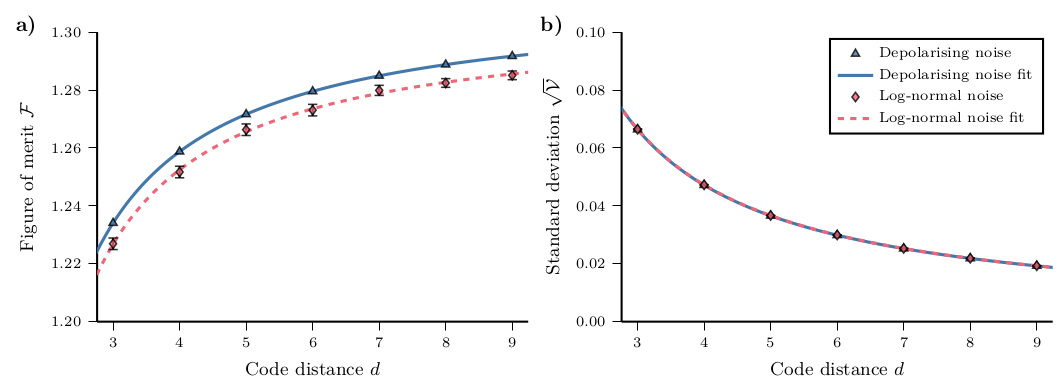

In [10]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising and lognormal noise
pad = 0.08
x_min = 3
x_int = 1
x_max = dist_max
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    palette=reverse(colour_series[1:4]), markersize=3, markeralpha=0.8,
    xlims=(x_min, x_max), xticks=x_min:x_int:x_max,
    xguide=L"\textrm{Code distance }d", xwiden=1 + pad,
    legend=:topright, legend_font_halign=:left)
# Figure of merit plot
y_min = 1.20
y_max = 1.30
y_int = 0.02
expectation_plot = scatter(dist_range, wls_expectation_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    markershape=:utriangle, color=colour_series[2], label="Depolarising noise",
    legend=false,
)
plot!(dense_range, wls_expectation_fit(dense_range);
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_expectation_scaling_log;
    yerror=2 * wls_sem_expectation_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, wls_expectation_fit_log(dense_range);
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
    extra_kwargs=:plot, add=raw"
    \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
    \node[anchor=south west] at (8.88-1.5,0.0-0.2) {\textbf{b)}};
")
# \node at (0.0,0.0) {\textbf{o}};
# \node at (8.88,0.0) {\textbf{o}};
# Standard deviation plot
y_min = 0.0
y_max = 0.10
y_int = 0.02
stdev_plot = scatter(dist_range, wls_stdev_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
    markershape=:utriangle,
    color=colour_series[2],
    label="Depolarising noise",
)
plot!(dense_range, sqrt.(wls_variance_fit(dense_range));
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_stdev_scaling_log;
    yerror=2 * wls_sem_stdev_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, sqrt.(wls_variance_fit_log(dense_range));
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
)
# Combined plot
combined_plot = plot(expectation_plot, stdev_plot; layout=(1, 2), size=(text_width_px * 0.991, col_height_px))
savefig(combined_plot, pwd() * "/figures/nrmse_scaling_$(unrotated_param.circuit_name).pdf")
display(combined_plot)

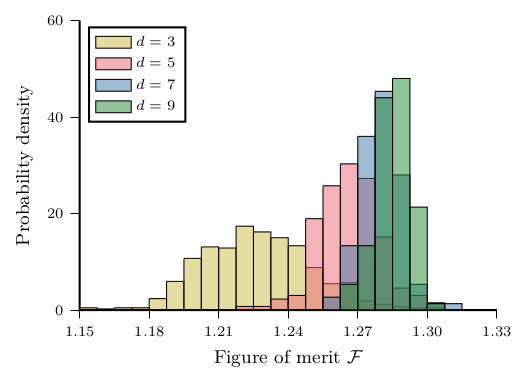

In [11]:
# Histogram of the figure of merit across instances of lognormal noise as a function of code distance
log_hist = histogram(
    wls_expectation_scaling_log[[1; 3; 5; 7]];
    labels=hcat([L"d = %$(d)" for d in dist_range[[1; 3; 5; 7]]]...),
    xlims=(1.15, 1.33), xticks=1.15:0.03:1.33, xwiden=1,
    xguide=L"\textrm{Figure of merit }\mathcal{F}",
    ylims=(0, 60), yticks=0:20:60,
    yguide="Probability density",
    bins=1.15:0.0075:1.33, normalize=:pdf,
    linewidth=0.5, legend=:topleft,
    size=(col_width_px, col_height_px),
)
plot_xlims = xlims(log_hist)
@assert plot_xlims[1] < minimum(minimum(wls_expectation_scaling_log)) && plot_xlims[2] > maximum(maximum(wls_expectation_scaling_log))
savefig(log_hist, pwd() * "/figures/nrmse_scaling_hist_$(unrotated_param.circuit_name).pdf")
display(log_hist)

#### Confirming fit parameterisation with the corrected Akaike information criterion

In [12]:
# Compare the AICc of different fit parameterisations
wls_trace_data = DataFrame(y=wls_trace_scaling, x=dist_range)
wls_trace_constant_model = lm(@formula(y ~ 1), wls_trace_data)
wls_trace_linear_model = lm(@formula(y ~ 1 + x), wls_trace_data)
wls_trace_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_data)
wls_trace_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_data)
wls_trace_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_data)
wls_trace_aicc = [aicc(wls_trace_constant_model); aicc(wls_trace_linear_model); aicc(wls_trace_quadratic_model); aicc(wls_trace_cubic_model); aicc(wls_trace_quartic_model)]
wls_trace_sq_data = DataFrame(y=wls_trace_sq_scaling, x=dist_range)
wls_trace_sq_constant_model = lm(@formula(y ~ 1), wls_trace_sq_data)
wls_trace_sq_linear_model = lm(@formula(y ~ 1 + x), wls_trace_sq_data)
wls_trace_sq_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_sq_data)
wls_trace_sq_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_sq_data)
wls_trace_sq_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_sq_data)
wls_trace_sq_aicc = [aicc(wls_trace_sq_constant_model); aicc(wls_trace_sq_linear_model); aicc(wls_trace_sq_quadratic_model); aicc(wls_trace_sq_cubic_model); aicc(wls_trace_sq_quartic_model)]
# Print AICc
header = [
    "Model"
    "AICc"
]
model_types = ["Constant"; "Linear"; "Quadratic"; "Cubic"; "Quartic"]
println("The corrected Akaike information criteria of polynomial fits of tr(Σ) are:")
pretty_table(
    hcat(model_types, wls_trace_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:")
pretty_table(
    hcat(model_types, wls_trace_sq_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The quadratic model is best according to the AICc in both instances.")

The corrected Akaike information criteria of polynomial fits of tr(Σ) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 146.86  │
│ Linear    │ 128.46  │
│ Quadratic │ -147.02 │
│ Cubic     │ -113.50 │
│ Quartic   │ Inf     │
└───────────┴─────────┘
The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 175.11  │
│ Linear    │ 156.91  │
│ Quadratic │ -123.72 │
│ Cubic     │ -90.43  │
│ Quartic   │ Inf     │
└───────────┴─────────┘
The quadratic model is best according to the AICc in both instances.


#### Plotting and displaying various quantities as a function of code distance across the different designs

In [13]:
# Initialise data
plot_labels = [L"\mathrm{GLS}", L"\mathrm{WLS}", L"\mathrm{WLS}^*", L"\mathrm{OLS}"]
labels = ["GLS", "WLS", "WLS (misoptim.)", "OLS", "Basic (WLS)"]
marker_shapes = [:diamond, :utriangle, :dtriangle, :pentagon]
expectation_set = [gls_expectation_scaling, wls_expectation_scaling, wls_worst_expectation_scaling, ols_expectation_scaling, triv_expectation_scaling]
expectation_fit_set = [gls_expectation_fit, wls_expectation_fit, wls_worst_expectation_fit, ols_expectation_fit, triv_expectation_fit]
stdev_set = [gls_stdev_scaling, wls_stdev_scaling, wls_worst_stdev_scaling, ols_stdev_scaling, triv_stdev_scaling]
stdev_fit_set = [gls_variance_fit, wls_variance_fit, wls_worst_variance_fit, ols_variance_fit, triv_variance_fit]
experiment_number_set = [gls_experiment_number_scaling, wls_experiment_number_scaling, wls_worst_experiment_number_scaling, ols_experiment_number_scaling, triv_experiment_number_scaling]
cond_num_set = [gls_cond_num_scaling, wls_cond_num_scaling, wls_worst_cond_num_scaling, ols_cond_num_scaling, triv_cond_num_scaling]
pinv_norm_set = [gls_pinv_norm_scaling, wls_pinv_norm_scaling, wls_worst_pinv_norm_scaling, ols_pinv_norm_scaling, triv_pinv_norm_scaling];

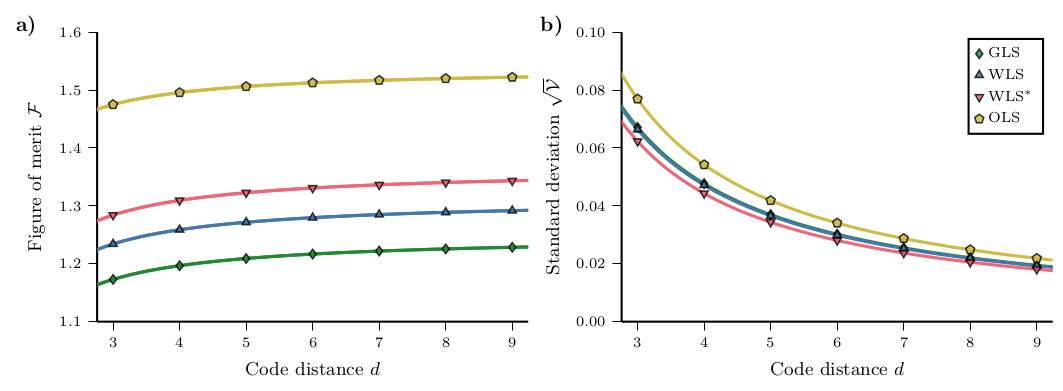

In [14]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising noise and a range of designs
# Figure of merit plot
y_min = 1.1
y_max = 1.6
y_int = 0.1
expectation_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    legend=false,
)
for idx in 1:4
    scatter!(dist_range, expectation_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
    )
    plot!(dense_range, expectation_fit_set[idx](dense_range);
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
    )
    if idx == 4
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
            extra_kwargs=:plot, add=raw"
            \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
            \node[anchor=south west] at (8.88-1.5,0.0-0.2) {\textbf{b)}};
            ")
        # \node at (0.0,0.0) {\textbf{o}};
        # \node at (8.88,0.0) {\textbf{o}};
    else
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
        )
    end
end
# Variance plot
y_min = 0.0
y_max = 0.10
y_int = 0.02
stdev_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
)
for idx in 1:4
    scatter!(dist_range, stdev_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
        label=plot_labels[idx],
    )
    plot!(dense_range, sqrt.(stdev_fit_set[idx](dense_range));
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
        label=nothing,
    )
end
# Combined plot
combined_set_plot = plot(expectation_set_plot, stdev_set_plot; size=(text_width_px * 0.991, col_height_px))
savefig(combined_set_plot, pwd() * "/figures/nrmse_scaling_$(unrotated_param.circuit_name)_combined.pdf")
display(combined_set_plot)

In [15]:
# Tables of the figure of merit and NRMSE standard deviation
println("The figures of merit for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; expectation_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("The NRMSE standard deviations for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; stdev_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)

The figures of merit for depolarising noise across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d │ GLS    │ WLS    │ WLS (misoptim.) │ OLS    │ Basic (WLS) │
├───┼────────┼────────┼─────────────────┼────────┼─────────────┤
│ 3 │ 1.1730 │ 1.2341 │ 1.2840          │ 1.4749 │ 3.7357      │
│ 4 │ 1.1967 │ 1.2587 │ 1.3094          │ 1.4955 │ 3.7644      │
│ 5 │ 1.2091 │ 1.2716 │ 1.3226          │ 1.5061 │ 3.7791      │
│ 6 │ 1.2167 │ 1.2795 │ 1.3308          │ 1.5125 │ 3.7880      │
│ 7 │ 1.2219 │ 1.2849 │ 1.3363          │ 1.5167 │ 3.7941      │
│ 8 │ 1.2256 │ 1.2888 │ 1.3403          │ 1.5198 │ 3.7984      │
│ 9 │ 1.2284 │ 1.2917 │ 1.3433          │ 1.5221 │ 3.8016      │
└───┴────────┴────────┴─────────────────┴────────┴─────────────┘
The NRMSE standard deviations for depolarising noise across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d │ GLS    │ WLS    │

In [16]:
# Table of experiment numbers
println("The experiment numbers across a range of designs and code distances are:")
pretty_table(hcat([[dist_range]; experiment_number_set]...); header=["d"; labels], alignment=:l)
println("All of these values are constant with code distance.")

The experiment numbers across a range of designs and code distances are:
┌───┬─────┬─────┬─────────────────┬─────┬─────────────┐
│ d │ GLS │ WLS │ WLS (misoptim.) │ OLS │ Basic (WLS) │
├───┼─────┼─────┼─────────────────┼─────┼─────────────┤
│ 3 │ 618 │ 582 │ 618             │ 588 │ 156         │
│ 4 │ 618 │ 582 │ 618             │ 588 │ 156         │
│ 5 │ 618 │ 582 │ 618             │ 588 │ 156         │
│ 6 │ 618 │ 582 │ 618             │ 588 │ 156         │
│ 7 │ 618 │ 582 │ 618             │ 588 │ 156         │
│ 8 │ 618 │ 582 │ 618             │ 588 │ 156         │
│ 9 │ 618 │ 582 │ 618             │ 588 │ 156         │
└───┴─────┴─────┴─────────────────┴─────┴─────────────┘
All of these values are constant with code distance.


In [17]:
# Table of condition numbers and pseudoinverse norms
println("The design matrix condition numbers across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; cond_num_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.2f"))
)
println("The design matrix pseudoinverse norms across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; pinv_norm_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("""
The condition numbers and pseudoinverse norms do not substantially change with code distance.
The optimised WLS design has a worse pseudoinverse norm than the worst-performing WLS design optimised for different noise parameters, despite performing better on the noise parameters of interest.""")

The design matrix condition numbers across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬───────┬─────────────┐
│ d │ GLS    │ WLS    │ WLS (misoptim.) │ OLS   │ Basic (WLS) │
├───┼────────┼────────┼─────────────────┼───────┼─────────────┤
│ 3 │ 182.71 │ 198.75 │ 415.51          │ 22.77 │ 28.67       │
│ 4 │ 182.95 │ 199.01 │ 416.05          │ 22.83 │ 29.78       │
│ 5 │ 183.12 │ 199.17 │ 416.40          │ 22.85 │ 30.24       │
│ 6 │ 183.23 │ 199.28 │ 416.65          │ 22.87 │ 30.48       │
│ 7 │ 183.30 │ 199.36 │ 416.83          │ 22.88 │ 30.62       │
│ 8 │ 183.36 │ 199.42 │ 416.96          │ 22.89 │ 30.71       │
│ 9 │ 183.41 │ 199.46 │ 417.06          │ 22.89 │ 30.76       │
└───┴────────┴────────┴─────────────────┴───────┴─────────────┘
The design matrix pseudoinverse norms across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d │ GLS    │ WLS    │ WLS (misoptim.) │ OLS    │ Basic 